### Theoretical Methods of Deep Learning: Homework assignment 1
Submit solution by uploading to canvas, **by Friday, November 6th, 23:00**

**The task.** Design a ReLU network with fewer than 10000 connections that approximates the function $f(x)=\sin x$ on the segment $[-\pi, \pi]$ with uniform error not greater than $10^{-12}$. Implement the network in a Python notebook. Count the number of connections and demonstrate that the error bound is satisfied.

In [3]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [4]:
PI = np.pi

class SinNetwork(nn.Module):
    def __init__(self, n_hidden, width):
        super().__init__()
        self.n_hidden = n_hidden
        self.width = width
        self.input_layer = nn.Linear(1, self.width)
        self.relu = nn.ReLU()
        
        hidden_layers = []
        for i in range(self.n_hidden - 1):
            hidden_layers.append(nn.Linear(self.width, self.width).to(device))
            hidden_layers.append(nn.ReLU())
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.output_layer = nn.Linear(self.width, 1)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.hidden_layers(x)
        
        return self.output_layer(x)
    
    def num_parameters(self):
        return 2 * self.width + (self.n_hidden - 1) * self.width * self.width
    
class SinDataset(torch.utils.data.Dataset):
    def __init__(self, n_points):
        super().__init__()
        self.n_points = n_points
        dx = 2*PI / n_points
        self.X = torch.arange(start=-PI, end=PI, step=dx)
        self.Y = torch.sin(self.X)
        
    def __len__(self):
        return self.n_points
    
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.Y[idx].unsqueeze(0)


def overfit(model, optimizer, criterion, loader, n_epochs=1000):
    print('Overfitting in progress..')
    for i in tqdm(range(n_epochs)):
        l = 0
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            l += loss.item()
    
    dx = 2*PI / N_POINTS
    x_range = torch.arange(start=-PI, end=PI, step=dx).to(device)
    y_range = torch.sin(x_range).to(device)
    y_pred = model(x_range.unsqueeze(1))
    
    print(f'Overfitting has finished, maximum error = {torch.max(torch.abs(y_pred.squeeze()-y_range))}')
            

In [5]:
N_POINTS = 10000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_hidden = 1
width = 5000

model = SinNetwork(n_hidden, width).to(device)
print(f'The number of connections is {model.num_parameters()}')

data = SinDataset(N_POINTS)
loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

overfit(model, optimizer, criterion, loader, n_epochs=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

The number of connections is 10000
Overfitting in progress..


100%|██████████| 10000/10000 [37:36<00:00,  4.43it/s]

Overfitting has finished, maximum error = 0.0010819584131240845


In [6]:
n_points = 10000

dx = 2*PI / n_points
x_range = torch.arange(start=-PI, end=PI, step=dx).to(device)
y_range = torch.sin(x_range).to(device)

y_pred = model(x_range.unsqueeze(1))
print(f'Maximum error = {torch.max(torch.abs(y_pred.squeeze()-y_range))}')

Maximum error = 0.0010819584131240845


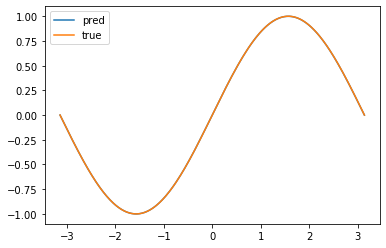

In [7]:
plt.plot(x_range.cpu(), y_pred.detach().cpu(), label='pred')
plt.plot(x_range.cpu(), y_range.detach().cpu(), label='true')
plt.legend()

### Doesn't work, let's try different loss which focuses on the points with maximal error
* Namely: $L(y_{true}, y_{pred}) = e^{|y_{true} - y_{pred}|}$

In [8]:
def overfit_exp(model, optimizer, criterion, loader, n_epochs=1000):
    print('Overfitting in progress..')
    for i in tqdm(range(n_epochs)):
        l = 0
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            loss = torch.exp(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            l += loss.item()
    
    dx = 2*PI / N_POINTS
    x_range = torch.arange(start=-PI, end=PI, step=dx).to(device)
    y_range = torch.sin(x_range).to(device)
    y_pred = model(x_range.unsqueeze(1))
    
    print(f'Overfitting has finished, maximum error = {torch.max(torch.abs(y_pred.squeeze()-y_range))}')

In [9]:
N_POINTS = 10000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_hidden = 1
width = 5000

model = SinNetwork(n_hidden, width).to(device)
print(f'The number of connections is {model.num_parameters()}')

data = SinDataset(N_POINTS)
loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

overfit_exp(model, optimizer, criterion, loader, n_epochs=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

The number of connections is 10000
Overfitting in progress..


100%|██████████| 10000/10000 [38:03<00:00,  4.38it/s]

Overfitting has finished, maximum error = 0.015954475849866867


In [10]:
n_points = 10000

dx = 2*PI / n_points
x_range = torch.arange(start=-PI, end=PI, step=dx).to(device)
y_range = torch.sin(x_range).to(device)

y_pred = model(x_range.unsqueeze(1))
print(f'Maximum error = {torch.max(torch.abs(y_pred.squeeze()-y_range))}')

Maximum error = 0.015954475849866867


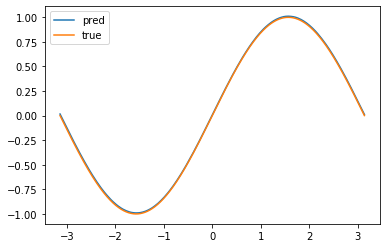

In [11]:
plt.plot(x_range.cpu(), y_pred.detach().cpu(), label='pred')
plt.plot(x_range.cpu(), y_range.detach().cpu(), label='true')
plt.legend()

### Doesn't work either

#### Let's try different approach: approximate $sin$ with it's Taylor series expanded at zero up to some high term
 $$sin(x) = x - \frac{x^3}{6}+\sum \frac{(-1)^k x^(2k+1)}{(2k+1)!} + \ ...$$
 * Each term will be computed using the sawtooth squaring approximation and multiplications in the form: $xy = \frac{1}{2}((x+y)^2 - x^2 - y^2)$

#### Let's define some basic blocks for this

In [45]:
PI = np.pi
powers_dict = {1: [1],     # 2
              2: [1, 1],   # 4
              3: [2, 1],   # 6
              4: [2, 2],   # 8
              5: [4, 1],   # 10
              6: [4, 2],   # 12
              7: [4, 3],   # 14
              8: [4, 4],   # 16
              9: [8, 1],   # 18
              10: [8, 2],  # 20
              11: [8, 3],  # 22
              12: [8, 4],  # 24
              13: [8, 5],  # 26
              14: [8, 6]    # 28
              }
# the reason not to use torch.relu is that it returns torch.tensor as the output and it can be inconvenient in some cases

def relu(x):
    return np.maximum(x, 0)

def sawtooth(x):
    return 2 * relu(x) - 4 * relu(x-0.5) + 2 * relu(x-1)

def sawtooth_squaring(x, depth=32):
    x_scaled = np.abs(x) / 1e7
    out = x_scaled
    num_connections = 8 * depth
    for i in range(depth):
        x_scaled = sawtooth(x_scaled)
        out -= np.power(2., -2*i - 2) * x_scaled
    out = out * 1e7 ** 2
    
    return out

def squaring_multiplication(x, y, squaring_depth=32):
    x_square = sawtooth_squaring(x, depth=squaring_depth)
    y_square = sawtooth_squaring(y, depth=squaring_depth)
    sum_square = sawtooth_squaring(x+y, depth=squaring_depth)
    return (sum_square - x_square - y_square) / 2

def sawtooth_sin(x):
    powers = np.zeros((len(x), 12))
    
    for i in range(12):
        if i == 0:
            powers[:, i] = 1
        elif i == 1:
            powers[:, i] = sawtooth_squaring(x)
        else:
            pwr1 = powers_dict[i][0]
            pwr2 = powers_dict[i][1]
            powers[:, i] = squaring_multiplication(powers[:, pwr1], powers[:, pwr2])
            
            
    
#     factorials = np.array([np.math.factorial(2*i+1) for i in range(14)])
#     ones = np.array([(-1) ** i for i in range(14)])
    for i in range(12):
        powers[:, i] = np.power(-1, i) * powers[:, i] / np.math.factorial(2*i + 1)
            
            
    #print(powers, factorials, ones)
    return squaring_multiplication(np.sum(powers, axis=1), x)
        
        

Each squaring adds depth*8 connections (32 * 8), each multiplication equals to 3 squarings + 3 connections for summation. My functions has 1 squaring + 10 multiplications 12 output connections, so the total number of connections is $256*3*10 + 256 + 256*3 + 12 = 8716$ connections. Even if my calculation is innacurate, I have a pretty big gap with the required number, so the actual number of connections is less than 10000 for sure.

In [48]:
256*3*10 + 256 + 256*3 + 12

8716

In [281]:
# test
squaring_multiplication(0.1, 0.2, squaring_depth=50)

0.020000000000000025

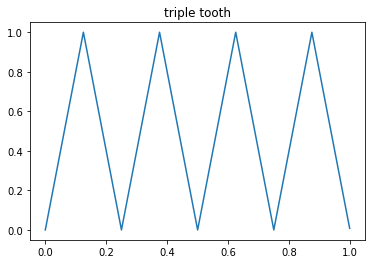

In [282]:
x_test = np.arange(0, 1, 0.001)
y_tooth = sawtooth(sawtooth(sawtooth(x_test)))
plt.plot(x_test, y_tooth)
_ = plt.title('triple tooth')

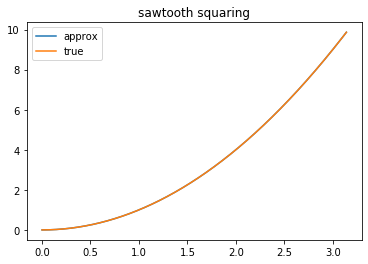

In [286]:
x_test = np.arange(0, PI, 0.001)
y_squared = sawtooth_squaring(x_test, depth=50)
plt.plot(x_test, y_squared, label='approx')
plt.plot(x_test, np.power(x_test, 2), label='true')
plt.title('sawtooth squaring')
plt.legend()
plt.show()

31416

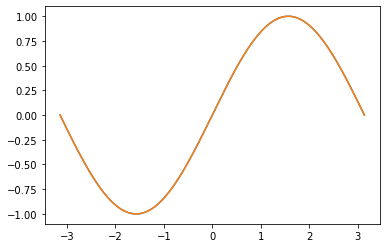

In [46]:
x_test = np.arange(-PI, PI, 0.0002)
    
plt.plot(x_test, sawtooth_sin(x_test))
plt.plot(x_test, np.sin(x_test))

len(x_test)

In [47]:
np.log(np.max(np.abs(sawtooth_sin(x_test) - np.sin(x_test))))

-13.305485391295516

Great!